<a href="https://colab.research.google.com/github/fay421/DL_Projects/blob/main/Hoda_Assignment_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Hoda Dataset from Github

In [1]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Receiving objects: 100% (24/24), 6.34 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## Read Dataset

In [2]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)])

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


## Seperate Data and Label

In [4]:
X_train, y_train = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Train 60000.cdb')
X_test, y_test = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Test 20000.cdb')

## Check the Dataset

In [ ]:
X_train.shape

(60000, 1024)

In [ ]:
y_train

array([6., 5., 0., ..., 2., 6., 6.], dtype=float32)

In [ ]:
X_test.shape

(20000, 1024)

## Visualization

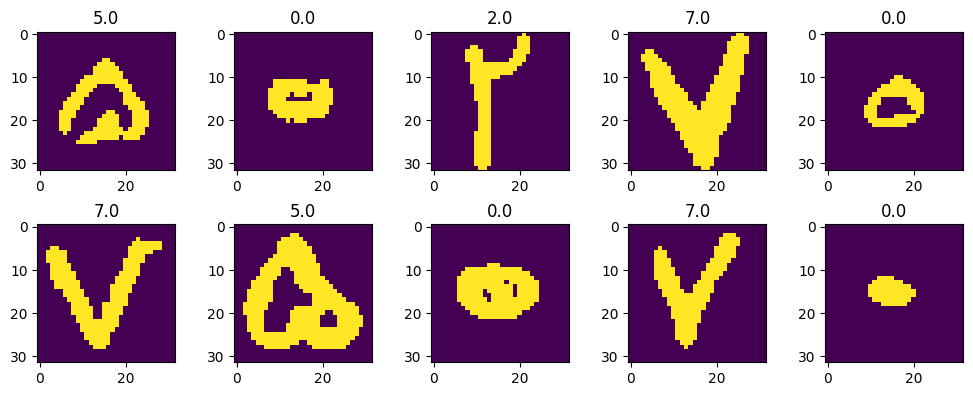

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,11):
  plt.subplot(2,5,i)
  plt.imshow(X_train[i].reshape(32,32))
  plt.title(y_train[i])
plt.tight_layout()
plt.show();

## ANN Model
### Import the libraries

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

## Build a Neural Network

In [ ]:
input_layer = Input(shape=(1024,) , name = 'input_layer')

In [ ]:
Layer_1 = Dense(32, activation = 'relu',name = 'Layer_1')(input_layer)
Layer_2 =Dense(64, activation ='relu',name = 'Layer_2')(Layer_1)
Layer_3 = Dense(32, activation = 'relu',name = 'Layer_3')(Layer_2)


In [ ]:
output = Dense(10 ,activation = 'softmax' ,name = 'output')(Layer_3)
model = Model(inputs = input_layer ,outputs = output)

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 32)                32800     
                                                                 
 Layer_2 (Dense)             (None, 64)                2112      
                                                                 
 Layer_3 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 37322 (145.79 KB)
Trainable params: 37322 (145.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Import optimizer, loss , metric

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score, Accuracy

In [ ]:
adam = Adam(learning_rate =0.001,beta_1=0.9,beta_2=0.999)
scce =SparseCategoricalCrossentropy()

## Compile Model

In [ ]:
model.compile(optimizer= adam,loss = scce, metrics=['accuracy'] )

In [ ]:
history = model.fit(X_train,y_train, epochs = 10,batch_size =32,
                    validation_data=(X_test,y_test),verbose= True )

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1762 - accuracy: 0.9493 - val_loss: 0.1558 - val_accuracy: 0.9527
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.1420 - val_accuracy: 0.9611
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0519 - accuracy: 0.9844 - val_loss: 0.1196 - val_accuracy: 0.9664
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.1100 - val_accuracy: 0.9695
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0331 - accuracy: 0.9894 - val_loss: 0.1168 - val_accuracy: 0.9661
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 0.1224 - val_accuracy: 0.9675
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.1540 - val_accuracy:

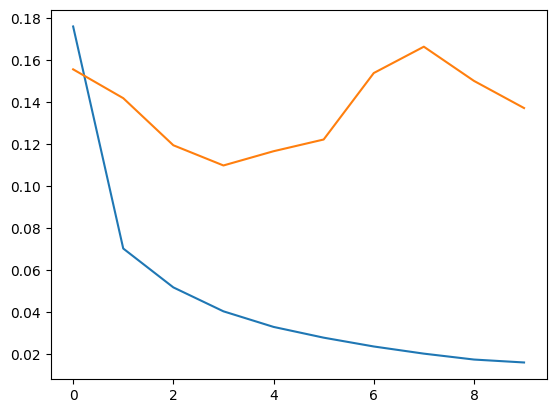

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

## Result for these parameters:


*   Learning_rate:0.001
*   epoch:10
*   Layers:32-64-32
*   acc: 0.9945  ,loss:0.0158  ,val_loss:0.1436, val_acc:0.9711



## The plot shows the training loss decreasing over time, which is a good sign as it indicates that the model is learning from the training data. However, the validation loss, after an initial decrease, starts to plateau and even slightly increase towards the end of the training epochs. This divergence between training loss and validation loss can be indicative of overfitting.

Overfitting occurs when the model learns patterns that are specific to the training data, which do not generalize well to unseen data. This is typically characterized by:

Training loss continuing to decrease.
Validation loss decreasing initially, but then increasing or plateauing.
Since the model is performing better on the training data than on the validation data (as suggested by the increasing gap between the training and validation loss), it may be memorizing the training data rather than learning generalizable features.

## To mitigate overfitting, we can consider the following strategies:

1- Add Dropout Layers: Introduce dropout layers to the network to prevent the model from relying too much on any given set of features.

2- Implement Early Stopping: Stop the training when the validation loss starts to increase to prevent overfitting.

3- Use Regularization Techniques: L1 or L2 regularization can be applied to the dense layers to constrain the weights during optimization.

4- Data Augmentation: Although not commonly used with non-image data, creating variations of your training data could help if applicable.

5- Reduce Model Complexity: Simplify the model by reducing the number of layers or the number of neurons in the layers.

6- Increase Data Quantity: If possible, increase the amount of training data to improve the generalization of the model.

7-Cross-Validation: Use k-fold cross-validation to ensure that the model is evaluated on different data splits.

## 1-Add DropOut

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,Dropout

In [ ]:
input_layer = Input(shape=(1024,) , name = 'input_layer')
Layer_1 = Dense(32, activation = 'relu',name = 'Layer_1')(input_layer)
Dropout_1 = Dropout(0.5,name ='Dropout_1')(Layer_1)
Layer_2 =Dense(64, activation ='relu',name = 'Layer_2')(Dropout_1)
Dropout_2 = Dropout(0.5, name='Dropout_2')(Layer_2)
Layer_3 = Dense(32, activation = 'relu',name = 'Layer_3')(Dropout_2)
Dropout_3 = Dropout(0.5,name='Dropout_3')(Layer_3)
output = Dense(10 ,activation = 'softmax' ,name = 'output')(Dropout_3)
model = Model(inputs = input_layer ,outputs = output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 32)                32800     
                                                                 
 Dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Layer_2 (Dense)             (None, 64)                2112      
                                                                 
 Dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 Layer_3 (Dense)             (None, 32)                2080      
                                                                 
 Dropout_3 (Dropout)         (None, 32)                0   

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score, Accuracy

In [ ]:
adam = Adam(learning_rate =0.001,beta_1=0.9,beta_2=0.999)
scce =SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer= adam,loss = scce, metrics=['accuracy'] )

In [ ]:
history = model.fit(X_train,y_train, epochs = 20,batch_size =32,
                    validation_data=(X_test,y_test),verbose= True )

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 1.0711 - accuracy: 0.6227 - val_loss: 0.4691 - val_accuracy: 0.8863
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7139 - accuracy: 0.7611 - val_loss: 0.4191 - val_accuracy: 0.8902
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6609 - accuracy: 0.7808 - val_loss: 0.3645 - val_accuracy: 0.9111
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6085 - accuracy: 0.8023 - val_loss: 0.3915 - val_accuracy: 0.9015
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5880 - accuracy: 0.8087 - val_loss: 0.3620 - val_accuracy: 0.9117
Epoch 6/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5715 - accuracy: 0.8158 - val_loss: 0.3468 - val_accuracy: 0.9118
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5566 - accuracy: 0.8222 - val_loss: 0.3202 - val_accuracy:

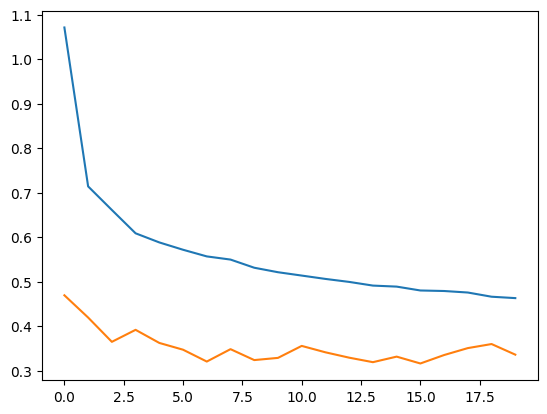

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

## Result for these parameters:
*   Learning_rate:0.001
*   epoch:20
*   Layers:32-dr-64-dr-32-dr
*   acc: 0.8493  ,loss:0.4628  ,val_loss:0.3357, val_acc:0.9168

Based on the new plot and the results ,the addition of dropout seems to have helped with overfitting. The validation loss appears to be consistently lower than the training loss, and there isn't a significant divergence between the two as the number of epochs increases. This indicates that the model is generalizing better to the unseen validation data.

The results showing a final training loss of 0.4628 and a validation loss of 0.3357 with accuracies of 84.93% and 91.68% for training and validation, respectively, suggest that the model is not overfitting, as the validation accuracy is actually higher than the training accuracy. However, the fact that the training loss is higher than the validation loss might suggest that the model could be underfitting.

Here are a few suggestions to potentially improve your model further:

1-Adjust Dropout Rate: A dropout rate of 0.5 is quite aggressive and might be causing underfitting. Consider reducing the dropout rate to a lower value, such as 0.3 or 0.2, and observe the impact on both training and validation loss.

2-Increase Model Capacity: If reducing the dropout doesn't lead to overfitting, you might want to increase the capacity of your model (i.e., adding more neurons or layers) to capture more complex patterns in the data.

3-Fine-Tune the Learning Rate: While the learning rate of 0.001 has helped mitigate overfitting, there might be room for optimization. Consider using learning rate scheduling or try a few different fixed learning rates to find the best fit.

4-Increase Epochs: Given that the validation loss is still decreasing, you could train for more epochs until the validation loss plateaus or starts to increase, which would be the point of overfitting.

5-Experiment with Batch Size: Changing the batch size can have a significant effect on the training dynamics. A smaller batch size often results in better generalization.

6-Data Preprocessing: If not already done, ensure that your data is properly normalized or standardized to help the training process.

7-Advanced Regularization Techniques: Besides dropout, you could experiment with other regularization methods like batch normalization or layer normalization.

8-Cross-validation: Use k-fold cross-validation to better estimate model performance and ensure that your results are consistent across different data splits.

## 2-Adjust Dropout Rate & Increase Epochs & Increase Model Capacity

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,Dropout

In [ ]:
input_layer = Input(shape=(1024,) , name = 'input_layer')
Layer_1 = Dense(128, activation = 'relu',name = 'Layer_1')(input_layer)
Dropout_1 = Dropout(0.5,name ='Dropout_1')(Layer_1)
Layer_2 =Dense(128, activation ='relu',name = 'Layer_2')(Dropout_1)
Dropout_2 = Dropout(0.5, name='Dropout_2')(Layer_2)
Layer_3 = Dense(64, activation = 'relu',name = 'Layer_3')(Dropout_2)
Dropout_3 = Dropout(0.5,name='Dropout_3')(Layer_3)
output = Dense(10 ,activation = 'softmax' ,name = 'output')(Dropout_3)
model = Model(inputs = input_layer ,outputs = output)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 128)               131200    
                                                                 
 Dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Layer_2 (Dense)             (None, 128)               16512     
                                                                 
 Dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 Layer_3 (Dense)             (None, 64)                8256      
                                                                 
 Dropout_3 (Dropout)         (None, 64)                0   

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score, Accuracy

In [ ]:
adam = Adam(learning_rate =0.0008,beta_1=0.9,beta_2=0.999)
scce =SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer= adam,loss = scce, metrics=['accuracy'] )

In [ ]:
history = model.fit(X_train,y_train, epochs = 25,batch_size =32,
                    validation_data=(X_test,y_test),verbose= True )

Epoch 1/25
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5000 - accuracy: 0.8449 - val_loss: 0.2364 - val_accuracy: 0.9313
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2170 - accuracy: 0.9445 - val_loss: 0.2021 - val_accuracy: 0.9460
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1748 - accuracy: 0.9546 - val_loss: 0.1844 - val_accuracy: 0.9536
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1557 - accuracy: 0.9602 - val_loss: 0.1601 - val_accuracy: 0.9588
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1428 - accuracy: 0.9641 - val_loss: 0.1580 - val_accuracy: 0.9603
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1279 - accuracy: 0.9672 - val_loss: 0.1489 - val_accuracy: 0.9621
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1195 - accuracy: 0.9690 - val_loss: 0.1318 - val_accuracy:

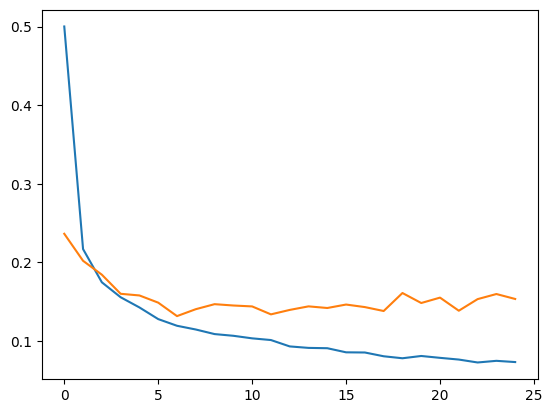

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

## Result for these parameters:
*   Learning_rate:0.0008
*   epoch:25
*   Layers:128-dr-128-dr-64-dr
*   DropOut_rate =0.5
*   acc: 0.9794  ,loss:0.0735  ,val_loss:0.1536, val_acc:0.97

Looking at the new plot and the results, there are a couple of observations we can make:

Training Loss vs. Validation Loss: The training loss has continued to decrease over the 25 epochs, indicating that the model is effectively learning from the training data. However, the validation loss seems to have plateaued and even increased slightly towards the end of the training epochs.

Overfitting Signs: There's a gap between the training and validation loss, which may be a sign of overfitting. Although the accuracy is high (97.94% for training and 97.00% for validation), the increasing gap between the training loss and validation loss could become problematic if the trend continues with more training.

Learning Rate and Dropout: You've adjusted the learning rate to 0.0008 and kept the dropout rate at 0.5. The learning rate seems to be okay since the training loss is steadily decreasing, but a dropout rate of 0.5 might still be high and could be contributing to the plateau in validation loss.

Here are some suggestions to improve the model:

1- Adjust Dropout Rate: Since you are still seeing some signs of overfitting, you could try decreasing the dropout rate slightly to see if the model can retain more information without overfitting. Values around 0.3 or 0.4 could be a good starting point.

2- Early Stopping: Implement early stopping with a patience parameter to stop training when the validation loss stops improving for a certain number of epochs.

3- Learning Rate Scheduling: Incorporate learning rate schedulers or reduce the learning rate on plateau. This can help the model to fine-tune the weights more effectively when it is closer to the minimum loss.

4- Model Complexity: If adjusting the dropout rate and learning rate does not help, you may need to experiment with the model complexity again, either by adding more neurons to existing layers or by adding additional layers.

5- Data Augmentation/Enrichment: Consider augmenting the dataset if possible, or generating synthetic data to provide the model with more varied examples.

6- Batch Normalization: If not already used, consider adding batch normalization layers, which can help in stabilizing the learning process and sometimes improve performance.

7- Experiment with Different Architectures: Sometimes, the architecture may not be suitable for the problem at hand. Experimenting with different architectures might yield better results.

## 3- Batch Normalization & Add more Neurons

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization,Activation

In [ ]:
input_layer = Input(shape=(1024,) , name = 'input_layer')
Layer_1 = Dense(32, activation = 'relu',name = 'Layer_1')(input_layer)
BatchNorm_1 = BatchNormalization(name='BatchNorm_1')(Layer_1)
Activation_1 = Activation('relu', name='Activation_1')(BatchNorm_1)
Dropout_1 = Dropout(0.3,name ='Dropout_1')(Activation_1)
Layer_2 =Dense(64, activation ='relu',name = 'Layer_2')(Dropout_1)
BatchNorm_2 = BatchNormalization(name='BatchNorm_2')(Layer_2)
Activation_2 = Activation('relu', name='Activation_2')(BatchNorm_2)
Dropout_2 = Dropout(0.3, name='Dropout_2')(Activation_2)
Layer_3 = Dense(64, activation = 'relu',name = 'Layer_3')(Dropout_2)
BatchNorm_3 = BatchNormalization(name='BatchNorm_3')(Layer_3)
Activation_3 = Activation('relu', name='Activation_3')(BatchNorm_3)
Dropout_3 = Dropout(0.3,name='Dropout_3')(Activation_3)
Layer_4 = Dense(64, name='Layer_4')(Dropout_3)
BatchNorm_4 = BatchNormalization(name='BatchNorm_4')(Layer_4)
Activation_4 = Activation('relu', name='Activation_4')(BatchNorm_4)
Dropout_4 = Dropout(0.3, name='Dropout_4')(Activation_4)
Layer_5 = Dense(32, name='Layer_5')(Dropout_4)
BatchNorm_5 = BatchNormalization(name='BatchNorm_5')(Layer_5)
Activation_5 = Activation('relu', name='Activation_5')(BatchNorm_5)
Dropout_5 = Dropout(0.3, name='Dropout_5')(Activation_5)
output = Dense(10, activation='softmax', name='output')(Dropout_5)
model = Model(inputs = input_layer ,outputs = output)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 32)                32800     
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 32)                128       
 ation)                                                          
                                                                 
 Activation_1 (Activation)   (None, 32)                0         
                                                                 
 Dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Layer_2 (Dense)             (None, 64)                2112      
                                                           

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score, Accuracy

In [ ]:
adam = Adam(learning_rate =0.0008,beta_1=0.9,beta_2=0.999)
scce =SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer= adam,loss = scce, metrics=['accuracy'] )

In [ ]:
history = model.fit(X_train,y_train, epochs = 25,batch_size =32,
                    validation_data=(X_test,y_test),verbose= True )

Epoch 1/25
1875/1875 [==============================] - 17s 7ms/step - loss: 1.2287 - accuracy: 0.5940 - val_loss: 0.5874 - val_accuracy: 0.8033
Epoch 2/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6948 - accuracy: 0.7705 - val_loss: 0.4378 - val_accuracy: 0.8397
Epoch 3/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.5645 - accuracy: 0.8071 - val_loss: 0.4053 - val_accuracy: 0.8431
Epoch 4/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5039 - accuracy: 0.8243 - val_loss: 0.3950 - val_accuracy: 0.8504
Epoch 5/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4756 - accuracy: 0.8321 - val_loss: 0.3612 - val_accuracy: 0.8548
Epoch 6/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4581 - accuracy: 0.8369 - val_loss: 0.3631 - val_accuracy: 0.8553
Epoch 7/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4320 - accuracy: 0.8430 - val_loss: 0.3572 - val_ac

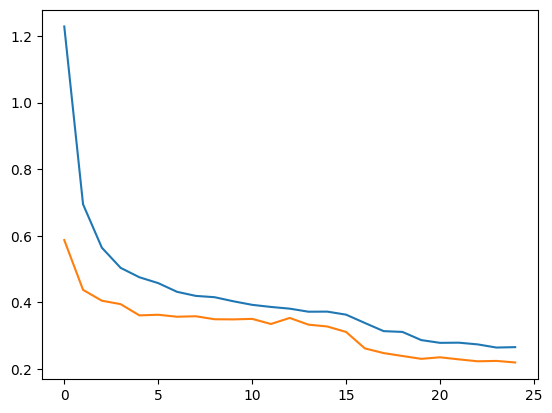

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

## Result for these parameters:
*   Learning_rate:0.0008
*   epoch:25
*   Layers:32-bn-af-dr-64-bn-af-dr64-bn-af-dr64-bn-af-dr-32-bn-af-dr
*   DropOut_rate =0.3
*   acc: 0.9359  ,loss:0.2659  ,val_loss:0.2198, val_acc:0.9408

The results and the plot indicate that the model is improving over time without clear signs of overfitting, as the validation loss is decreasing alongside the training loss.

The training seems to progress well with the following observations:

Both the training and validation loss are decreasing, which is a good sign of learning.
The validation loss has moments where it plateaus or slightly increases but overall trends downward, suggesting that the model has not yet overfit.
The accuracy is improving significantly over epochs, reaching over 93% on both training and validation sets, which is excellent.
Given these points, here are a few suggestions you might consider going forward:

Learning Rate Scheduling: You might benefit from implementing learning rate schedulers that can adjust the learning rate during training, such as reducing it when the validation loss plateaus.

Early Stopping: To ensure that you don't start overfitting if you continue to train for more epochs, consider implementing early stopping with a patience parameter that stops training when the validation loss does not improve for a given number of epochs.

Refinement of Dropout: The dropout rate of 0.3 seems to be working well, but you can always try fine-tuning it (either up or down) to see if it results in better performance.

Model Complexity: Since the model is performing well, you might not need to increase complexity by adding more layers. However, if you want to experiment, you could add one more dense layer and see if that helps the model capture more complex patterns without overfitting.

Further Training: It seems that your model could benefit from more training since the validation loss is still decreasing. You can continue training for more epochs until you see clear signs of overfitting (an increase in validation loss) or until the validation loss plateaus.

Model Evaluation: To further evaluate model performance, consider looking at other metrics such as precision, recall, and the F1 score, especially if you're dealing with an imbalanced dataset.

Data Augmentation: If your data allows for it, you could generate more training samples through data augmentation techniques, which can sometimes help improve the model's generalization capabilities.